/Users/alandegenhart/src/neuropy/util/convertmat.py:160: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  data_list = dataset.value
/Users/alandegenhart/src/neuropy/util/convertmat.py:157: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  for ref in dataset.value.flatten()


Redecode accuracy: 2.83e-14 (mean), 2.13e-13 (max)
Redecode accuracy: 1.95e-14 (mean), 1.42e-13 (max)


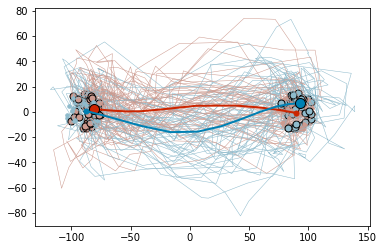

In [1]:

# %% Setup -- import modules, etc.

# Standard modules
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Custom modules
sys.path.append('/Users/alandegenhart/src/')
import neuropy as neu
from neuropy.analysis import gpfa
import neuropy.temp as tmp

# Setup autoreload
%reload_ext autoreload
%autoreload 2

# %%

# Define data paths
base_dir = os.path.join(os.sep, 'Volumes', 'Samsung_T5', 'Batista', 'Animals')
subject = 'Earl'
dataset = '20180927'
data_dir = os.path.join(
    base_dir, subject, dataset[0:4], dataset[4:6], dataset
)
save_dir = os.path.join(data_dir, 'translated', 'pandasData')
dataset_name = [
    'Earl20180927_04_condGridTask_01_SI_exportData.hdf',
    'Earl20180927_05_twoTargetABBA_rotated_01_SI_exportData.hdf'
]

# Load data
df_int = pd.read_hdf(os.path.join(save_dir, dataset_name[0]), 'df')
df_rot = pd.read_hdf(os.path.join(save_dir, dataset_name[1]), 'df')

# %% Load decoder and GPFA parameters

# Get decoder names
int_dec_path = os.path.join(data_dir, df_int['decoderName'].iloc[0] + '.mat')
rot_dec_path = os.path.join(data_dir, df_rot['decoderName'].iloc[0] + '.mat')

# Load decoding parameters and GPFA results
dec_int = neu.util.convertmat.convert_mat(int_dec_path)['bci_params']
dec_rot = neu.util.convertmat.convert_mat(rot_dec_path)['bci_params']
neu.el.proc.clean_bci_params(dec_int)
neu.el.proc.clean_bci_params(dec_rot)

# Define paths to GPFA data
gpfa_results_dir = os.path.join(data_dir, 'analysis', 'mat_results')
int_dec_num = 5  # Need to re-convert data to get this from the params
rot_dec_num = 10 # Need to re-convert data to get this from the params
int_gpfa_path = os.path.join(
    gpfa_results_dir,
    'run{:03d}'.format(int_dec_num),
    'gpfa_xDim{}.mat'.format(dec_int['xDim'])
)
rot_gpfa_path = os.path.join(
    gpfa_results_dir,
    'run{:03d}'.format(rot_dec_num),
    'gpfa_xDim{}.mat'.format(dec_rot['xDim'])
)
int_gpfa_path = os.path.join(gpfa_results_dir, int_gpfa_path)
rot_gpfa_path = os.path.join(gpfa_results_dir, rot_gpfa_path)

# Load GPFA data
gpfa_int = neu.util.convertmat.convert_mat(int_gpfa_path)['estParams']
gpfa_rot = neu.util.convertmat.convert_mat(rot_gpfa_path)['estParams']
neu.el.proc.clean_gpfa_params(gpfa_int)
neu.el.proc.clean_gpfa_params(gpfa_rot)

# %% Check re-decoded trajectories

# Check re-decode accuracy (intuitive)
dif = neu.el.validation.redecode_cursor_pos(
    df_int['decodeSpikeCounts'], df_int['decodeState'], dec_int
)

# Check re-decode accuracy (rotated)
dif = neu.el.validation.redecode_cursor_pos(
    df_rot['decodeSpikeCounts'], df_rot['decodeState'], dec_rot
)

# %% Transform neural trajectories

# Orthonormalize
C_orth, T, s, VH = gpfa.orthogonalize(gpfa_int['C'])

# Get neural trajectories
U = df_int['decodeSpikeCounts'].apply(
    neu.analysis.gpfa.extract_causal_traj, args=(dec_int,)
)
U.iloc[0].shape

# Transform to orthonormalized latents
U_orth = U.apply(lambda x: T @ x)
U_orth.iloc[0].shape


# %% Get onset and offset of trajectories

# Find onset/offset and add back to dataframe.
onset_idx_int = df_int.apply(tmp.find_traj_onset, axis=1, result_type='expand')
df_int['trajOnsetIdx'] = onset_idx_int['trajOnset']
df_int['trajOffsetIdx'] = onset_idx_int['trajOffset']
onset_idx_rot = df_rot.apply(tmp.find_traj_onset, axis=1, result_type='expand')
df_rot['trajOnsetIdx'] = onset_idx_rot['trajOnset']
df_rot['trajOffsetIdx'] = onset_idx_rot['trajOffset']

# %% Get target conditions

# Define target combinations
start_pos = np.concatenate(df_int['startPos'])
end_pos = np.concatenate(df_int['targPos'])
targ_comb = np.concatenate([start_pos, end_pos], axis=1)
uni_targ_comb = np.unique(targ_comb, axis=0)

# Convert target combinations to trial conditions
start_cond = tmp.get_targ_cond(df_int['startPos'])
end_cond = tmp.get_targ_cond(df_int['targPos'])
targ_cond = [''.join([s, e]) for s, e in zip(start_cond, end_cond)]
mask = tmp.get_targ_pairs(start_cond, end_cond)
col_map = tmp.define_color_map()

# %% Plot trajectories

# Get new truncated trajectory values
traj_valid = df_int.apply(
    lambda x: x['decodeState'][:, x['trajOnsetIdx']:(x['trajOffsetIdx'] + 1)],
    axis='columns')

# Plot all trajectories
tmp.plot_traj(
    traj_valid[mask],
    pd.Series(targ_cond)[mask],
    col_map,
    col_mode='light',
    line_width=0.5,
    marker_size=7)

# Plot average trajectories

# Get unique paired target conditions
uni_targ_cond = set([c for c, m in zip(targ_cond, mask) if m])

for uc in uni_targ_cond:
    # Get subset of trials for a single target condition and average
    cond_mask = [True if tc == uc else False for tc in targ_cond]
    avg_traj = tmp.spatial_average(traj_valid[cond_mask])

    # Plot average trajectory
    tmp.plot_single_traj(avg_traj, uc, col_map, line_width=2)

# Display plot
plt.show()


# %% Next steps

# Things to do soon:
# TODO: flip y-axis of decode state (currently this is in the Host coordinate system)
# TODO: trajectory plotting - int and rotated in the same projection
# TODO: new color mapping with slightly different colors for intuitive and rotated
# TODO: Implement FlowField class
#    - Fit method
#    - Can have child classes that implement different methods
#    - Voxel method
#    - Distance-weighted average method
#    - NN-based method

# Analysis:
# - Plot trajectories for different mappings (int and rotated) for each condition
# - Calculate the flow field for a single condition/mapping dataset
# - Method to plot a flow field
# - Quantification of similarity for two flow fields
# - Random projections

# Things to do eventually:
# TODO: Outer wrapper to generate plots (create figure layout, etc.)
# TODO: Add target plotting
# TODO: `load_test.py` will need to be turned into a more standalone function to
#   batch iterate over datasets
# TODO: Look into Pandas pickle warnings in `load_test.py`
